# Audio Binary Classification: Barbie VS Puppy


In [160]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Используется устройство: {device}")

Используется устройство: mps


In [161]:
DATA_DIR = Path('./dataset')
SAMPLE_RATE = 22050
DURATION = 5
N_SAMPLES = SAMPLE_RATE * DURATION

BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.0001
AUGMENTATION_MULTIPLIER = 8  # увелечение датасета за счет аугментаций

In [162]:
def load_audio_files(data_dir):
    audio_files = []
    labels = []

    barbie_dir = data_dir / 'barbie'
    if barbie_dir.exists():
        for audio_path in barbie_dir.glob('*.wav'):
            audio_files.append(str(audio_path))
            labels.append(0)

    puppy_dir = data_dir / 'puppy'
    if puppy_dir.exists():
        for audio_path in puppy_dir.glob('*.wav'):
            audio_files.append(str(audio_path))
            labels.append(1)
    
    df = pd.DataFrame({
        'file_path': audio_files,
        'label': labels,
        'class_name': ['barbie' if l == 0 else 'puppy' for l in labels]
    })
    
    return df

df = load_audio_files(DATA_DIR)
print(f"Всего аудио файлов: {len(df)}")
print(f"\nРаспределение по классам:")
print(df['class_name'].value_counts())
df.head()

Всего аудио файлов: 98

Распределение по классам:
class_name
barbie    50
puppy     48
Name: count, dtype: int64


,file_path,label,class_name
0,dataset/barbie/barbie_28.wav,0,barbie
1,dataset/barbie/barbie_14.wav,0,barbie
2,dataset/barbie/barbie_15.wav,0,barbie
3,dataset/barbie/barbie_29.wav,0,barbie
4,dataset/barbie/barbie_17.wav,0,barbie


## ИСПРАВЛЕННАЯ Аугментация данных

In [163]:
import audiomentations as A

augmentation_pipeline = A.Compose([
    # Изменение высоты тона
    A.PitchShift(min_semitones=-4, max_semitones=4, p=0.7),
    
    # Изменение скорости
    A.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.7),
    
    # Добавление белого шума
    A.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.6),
    
    # Изменение громкости
    A.Gain(min_gain_db=-12, max_gain_db=12),

    A.Shift(min_shift=-0.3, max_shift=0.3),
    
    # Нормализация
    A.Normalize(p=0.5),
    
    # Полярная инверсия
    A.PolarityInversion(p=0.3),
    
    # Low pass filter
    A.LowPassFilter(min_cutoff_freq=1500, max_cutoff_freq=7000, p=0.4),
    
    # High pass filter
    A.HighPassFilter(min_cutoff_freq=20, max_cutoff_freq=2400, p=0.4),
    
    # Band pass filter
    A.BandPassFilter(min_center_freq=200, max_center_freq=4000, p=0.3),
    
    # Clipping distortion
    A.ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=10, p=0.3),
])

In [164]:
def load_and_preprocess_audio(file_path, target_length=N_SAMPLES):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        
        return audio
    except Exception as e:
        print(f"Ошибка загрузки {file_path}: {e}")
        return None

In [165]:
def extract_logmel(audio, n_mels=128, n_fft=2048, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=SAMPLE_RATE,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec

def extract_mfcc_delta(audio, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    combined = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    return combined

## УЛУЧШЕННАЯ архитектура CNN с регуляризацией

In [166]:
class ImprovedAudioCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


test_model = ImprovedAudioCNN()
print(f"Количество параметров: {sum(p.numel() for p in test_model.parameters()):,}")

Количество параметров: 97,890


## Dataset с аугментацией

In [167]:
class AugmentedAudioDataset(Dataset):
    def __init__(self, file_paths, labels, feature_type='logmel', 
                 augmentation=None, augment_multiplier=1):
        self.file_paths = file_paths
        self.labels = labels
        self.feature_type = feature_type
        self.augmentation = augmentation
        self.augment_multiplier = augment_multiplier

        if augment_multiplier > 1:
            self.file_paths = file_paths * augment_multiplier
            self.labels = labels * augment_multiplier
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        audio = load_and_preprocess_audio(self.file_paths[idx])
        
        if audio is None:
            return torch.zeros((1, 128, 216)), self.labels[idx]

        if self.augmentation is not None:
            audio = self.augmentation(samples=audio, sample_rate=SAMPLE_RATE)

        if self.feature_type == 'logmel':
            features = extract_logmel(audio)
        elif self.feature_type == 'mfcc_delta':
            features = extract_mfcc_delta(audio)

        features = torch.FloatTensor(features).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return features, label

## Разделение данных

In [168]:
file_paths = df['file_path'].values
labels = df['label'].values

train_val_files, test_files, train_val_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.15, random_state=42, stratify=labels
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_val_files, train_val_labels, test_size=0.15, random_state=42, stratify=train_val_labels
)

print(f"Train: {len(train_files)} файлов")
print(f"Val: {len(val_files)} файлов")
print(f"Test: {len(test_files)} файлов")
print(f"Train: {len(train_files) * AUGMENTATION_MULTIPLIER}")

Train: 70 файлов
Val: 13 файлов
Test: 15 файлов
Train: 560


## Функция обучения с Early Stopping и LR Scheduler

In [169]:
def train_model_improved(model, train_loader, val_loader, criterion, optimizer, 
                        scheduler, num_epochs=100, patience=15, device=device):
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f'Новая лучшая модель! Val Acc: {val_acc:.4f}')
        else:
            patience_counter += 1
            print(f'Patience: {patience_counter}/{patience}')
        
        if patience_counter >= patience:
            print(f'\nEarly stopping на эпохе {epoch+1}')
            break

    model.load_state_dict(best_model_state)
    
    return model, history

In [170]:
def evaluate_model(model, test_loader, device=device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, 
                                target_names=['Barbie', 'Puppy']))

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Barbie', 'Puppy'],
                yticklabels=['Barbie', 'Puppy'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return accuracy, f1

## Обучение с LogMel спектрограммами

ОБУЧЕНИЕ С LOGMEL СПЕКТРОГРАММАМИ


Epoch 1/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 0.6914, Train Acc: 0.5643
Val Loss: 0.7197, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Новая лучшая модель! Val Acc: 0.5385


Epoch 2/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 0.6657, Train Acc: 0.6125
Val Loss: 0.7217, Val Acc: 0.4615
LR: 0.000100
------------------------------------------------------------
Patience: 1/15


Epoch 3/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 0.6566, Train Acc: 0.6107
Val Loss: 0.7303, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Patience: 2/15


Epoch 4/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 0.6610, Train Acc: 0.6268
Val Loss: 0.7085, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Patience: 3/15


Epoch 5/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 0.6597, Train Acc: 0.5911
Val Loss: 0.7400, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Patience: 4/15


Epoch 6/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 0.6449, Train Acc: 0.6304
Val Loss: 0.6856, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Patience: 5/15


Epoch 7/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 0.6225, Train Acc: 0.6607
Val Loss: 0.6566, Val Acc: 0.6154
LR: 0.000100
------------------------------------------------------------
Новая лучшая модель! Val Acc: 0.6154


Epoch 8/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 0.6267, Train Acc: 0.6625
Val Loss: 0.6680, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Patience: 1/15


Epoch 9/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 0.6107, Train Acc: 0.6768
Val Loss: 0.5988, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Patience: 2/15


Epoch 10/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 0.5981, Train Acc: 0.6839
Val Loss: 0.6912, Val Acc: 0.6154
LR: 0.000100
------------------------------------------------------------
Patience: 3/15


Epoch 11/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 0.6501, Train Acc: 0.6500
Val Loss: 0.6429, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Patience: 4/15


Epoch 12/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 0.5973, Train Acc: 0.6875
Val Loss: 0.6021, Val Acc: 0.6923
LR: 0.000100
------------------------------------------------------------
Новая лучшая модель! Val Acc: 0.6923


Epoch 13/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 0.5965, Train Acc: 0.6857
Val Loss: 0.5819, Val Acc: 0.6923
LR: 0.000100
------------------------------------------------------------
Patience: 1/15


Epoch 14/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 0.5737, Train Acc: 0.7286
Val Loss: 0.5605, Val Acc: 0.6154
LR: 0.000100
------------------------------------------------------------
Patience: 2/15


Epoch 15/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 0.6093, Train Acc: 0.6607
Val Loss: 0.6021, Val Acc: 0.6154
LR: 0.000100
------------------------------------------------------------
Patience: 3/15


Epoch 16/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 0.5894, Train Acc: 0.7143
Val Loss: 0.5180, Val Acc: 0.6923
LR: 0.000100
------------------------------------------------------------
Patience: 4/15


Epoch 17/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 0.5623, Train Acc: 0.7036
Val Loss: 0.5652, Val Acc: 0.6154
LR: 0.000100
------------------------------------------------------------
Patience: 5/15


Epoch 18/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 0.5682, Train Acc: 0.7321
Val Loss: 0.5673, Val Acc: 0.6154
LR: 0.000100
------------------------------------------------------------
Patience: 6/15


Epoch 19/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 0.5660, Train Acc: 0.7250
Val Loss: 0.5810, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Patience: 7/15


Epoch 20/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 0.5445, Train Acc: 0.7304
Val Loss: 0.5810, Val Acc: 0.6923
LR: 0.000100
------------------------------------------------------------
Patience: 8/15


Epoch 21/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 0.5242, Train Acc: 0.7821
Val Loss: 0.5423, Val Acc: 0.6923
LR: 0.000100
------------------------------------------------------------
Patience: 9/15


Epoch 22/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 0.5364, Train Acc: 0.7536
Val Loss: 0.5380, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Новая лучшая модель! Val Acc: 0.7692


Epoch 23/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 23/100
Train Loss: 0.5279, Train Acc: 0.7571
Val Loss: 0.4867, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 1/15


Epoch 24/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 24/100
Train Loss: 0.4990, Train Acc: 0.7804
Val Loss: 0.4908, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 2/15


Epoch 25/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 25/100
Train Loss: 0.5197, Train Acc: 0.7571
Val Loss: 0.4730, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 3/15


Epoch 26/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 26/100
Train Loss: 0.5142, Train Acc: 0.7696
Val Loss: 0.5018, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 4/15


Epoch 27/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 27/100
Train Loss: 0.4878, Train Acc: 0.7911
Val Loss: 0.4917, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 5/15


Epoch 28/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 28/100
Train Loss: 0.4832, Train Acc: 0.7875
Val Loss: 0.4626, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 6/15


Epoch 29/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 29/100
Train Loss: 0.5018, Train Acc: 0.7679
Val Loss: 0.5590, Val Acc: 0.6154
LR: 0.000050
------------------------------------------------------------
Patience: 7/15


Epoch 30/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 30/100
Train Loss: 0.4729, Train Acc: 0.7946
Val Loss: 0.4699, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 8/15


Epoch 31/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 31/100
Train Loss: 0.4864, Train Acc: 0.7893
Val Loss: 0.5170, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 9/15


Epoch 32/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 32/100
Train Loss: 0.4930, Train Acc: 0.7946
Val Loss: 0.4466, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 10/15


Epoch 33/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 33/100
Train Loss: 0.4963, Train Acc: 0.7750
Val Loss: 0.4925, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 11/15


Epoch 34/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 34/100
Train Loss: 0.4607, Train Acc: 0.8161
Val Loss: 0.4991, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 12/15


Epoch 35/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 35/100
Train Loss: 0.4603, Train Acc: 0.8321
Val Loss: 0.4461, Val Acc: 0.8462
LR: 0.000050
------------------------------------------------------------
Новая лучшая модель! Val Acc: 0.8462


Epoch 36/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 36/100
Train Loss: 0.4663, Train Acc: 0.8018
Val Loss: 0.4416, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 1/15


Epoch 37/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 37/100
Train Loss: 0.4670, Train Acc: 0.8107
Val Loss: 0.4727, Val Acc: 0.9231
LR: 0.000050
------------------------------------------------------------
Новая лучшая модель! Val Acc: 0.9231


Epoch 38/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 38/100
Train Loss: 0.4603, Train Acc: 0.8107
Val Loss: 0.5076, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 1/15


Epoch 39/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 39/100
Train Loss: 0.4464, Train Acc: 0.8232
Val Loss: 0.4628, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 2/15


Epoch 40/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 40/100
Train Loss: 0.4276, Train Acc: 0.8375
Val Loss: 0.4721, Val Acc: 0.8462
LR: 0.000050
------------------------------------------------------------
Patience: 3/15


Epoch 41/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 41/100
Train Loss: 0.4819, Train Acc: 0.7571
Val Loss: 0.4490, Val Acc: 0.8462
LR: 0.000050
------------------------------------------------------------
Patience: 4/15


Epoch 42/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 42/100
Train Loss: 0.4536, Train Acc: 0.8071
Val Loss: 0.4156, Val Acc: 0.9231
LR: 0.000050
------------------------------------------------------------
Patience: 5/15


Epoch 43/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 43/100
Train Loss: 0.4766, Train Acc: 0.7875
Val Loss: 0.4640, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 6/15


Epoch 44/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 44/100
Train Loss: 0.4360, Train Acc: 0.8429
Val Loss: 0.4152, Val Acc: 0.8462
LR: 0.000050
------------------------------------------------------------
Patience: 7/15


Epoch 45/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 45/100
Train Loss: 0.4254, Train Acc: 0.8339
Val Loss: 0.4053, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 8/15


Epoch 46/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 46/100
Train Loss: 0.4370, Train Acc: 0.8000
Val Loss: 0.4968, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 9/15


Epoch 47/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 47/100
Train Loss: 0.4345, Train Acc: 0.8179
Val Loss: 0.4893, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 10/15


Epoch 48/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 48/100
Train Loss: 0.4190, Train Acc: 0.8482
Val Loss: 0.5193, Val Acc: 0.6154
LR: 0.000050
------------------------------------------------------------
Patience: 11/15


Epoch 49/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 49/100
Train Loss: 0.4268, Train Acc: 0.8107
Val Loss: 0.4855, Val Acc: 0.6923
LR: 0.000050
------------------------------------------------------------
Patience: 12/15


Epoch 50/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 50/100
Train Loss: 0.4643, Train Acc: 0.8018
Val Loss: 0.4635, Val Acc: 0.7692
LR: 0.000050
------------------------------------------------------------
Patience: 13/15


Epoch 51/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 51/100
Train Loss: 0.4123, Train Acc: 0.8429
Val Loss: 0.4278, Val Acc: 0.8462
LR: 0.000025
------------------------------------------------------------
Patience: 14/15


Epoch 52/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 52/100
Train Loss: 0.4208, Train Acc: 0.8411
Val Loss: 0.4253, Val Acc: 0.7692
LR: 0.000025
------------------------------------------------------------
Patience: 15/15

Early stopping на эпохе 52
РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (LogMel)

Test Accuracy: 0.8667
Test F1-Score: 0.8655

Classification Report:
              precision    recall  f1-score   support

      Barbie       1.00      0.75      0.86         8
       Puppy       0.78      1.00      0.88         7

    accuracy                           0.87        15
   macro avg       0.89      0.88      0.87        15
weighted avg       0.90      0.87      0.87        15



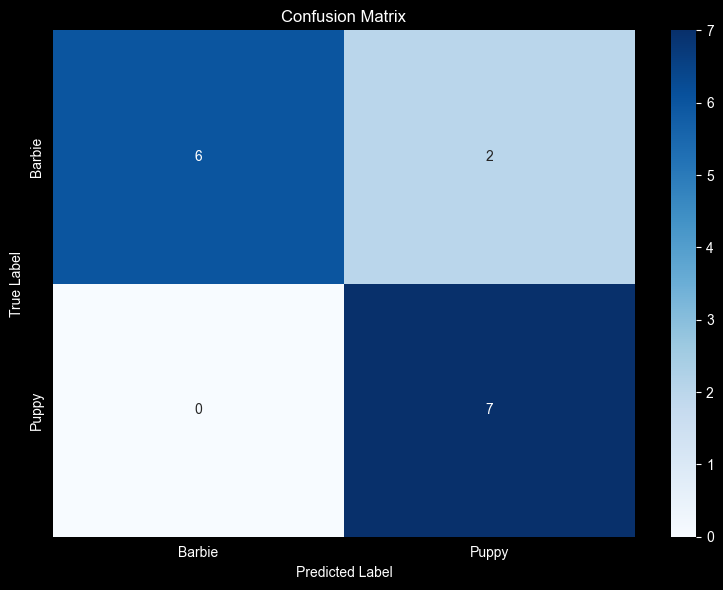

In [171]:
print("ОБУЧЕНИЕ С LOGMEL СПЕКТРОГРАММАМИ")

train_dataset = AugmentedAudioDataset(
    train_files.tolist(), 
    train_labels.tolist(),
    feature_type='logmel',
    augmentation=augmentation_pipeline,
    augment_multiplier=AUGMENTATION_MULTIPLIER
)

val_dataset = AugmentedAudioDataset(
    val_files.tolist(),
    val_labels.tolist(),
    feature_type='logmel',
    augmentation=None,
    augment_multiplier=1
)

test_dataset = AugmentedAudioDataset(
    test_files.tolist(),
    test_labels.tolist(),
    feature_type='logmel',
    augmentation=None,
    augment_multiplier=1
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model_logmel = ImprovedAudioCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_logmel.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

model_logmel, history_logmel = train_model_improved(
    model_logmel, train_loader, val_loader, criterion, optimizer, 
    scheduler, num_epochs=EPOCHS, patience=15
)

print("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (LogMel)")
test_acc_logmel, test_f1_logmel = evaluate_model(model_logmel, test_loader)

## Обучение с MFCC+Delta

ОБУЧЕНИЕ С MFCC+DELTA


Epoch 1/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 0.6929, Train Acc: 0.5071
Val Loss: 0.7009, Val Acc: 0.3846
LR: 0.000100
------------------------------------------------------------
Новая лучшая модель! Val Acc: 0.3846


Epoch 2/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 2/100
Train Loss: 0.6958, Train Acc: 0.4839
Val Loss: 0.7037, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Новая лучшая модель! Val Acc: 0.5385


Epoch 3/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3/100
Train Loss: 0.6887, Train Acc: 0.5196
Val Loss: 0.7033, Val Acc: 0.5385
LR: 0.000100
------------------------------------------------------------
Patience: 1/15


Epoch 4/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 4/100
Train Loss: 0.6771, Train Acc: 0.5821
Val Loss: 0.7221, Val Acc: 0.3846
LR: 0.000100
------------------------------------------------------------
Patience: 2/15


Epoch 5/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5/100
Train Loss: 0.6790, Train Acc: 0.5696
Val Loss: 0.7207, Val Acc: 0.4615
LR: 0.000100
------------------------------------------------------------
Patience: 3/15


Epoch 6/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6/100
Train Loss: 0.6814, Train Acc: 0.5464
Val Loss: 0.7240, Val Acc: 0.3846
LR: 0.000100
------------------------------------------------------------
Patience: 4/15


Epoch 7/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 7/100
Train Loss: 0.6829, Train Acc: 0.5571
Val Loss: 0.7214, Val Acc: 0.6154
LR: 0.000050
------------------------------------------------------------
Новая лучшая модель! Val Acc: 0.6154


Epoch 8/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8/100
Train Loss: 0.6732, Train Acc: 0.5839
Val Loss: 0.7170, Val Acc: 0.3077
LR: 0.000050
------------------------------------------------------------
Patience: 1/15


Epoch 9/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9/100
Train Loss: 0.6778, Train Acc: 0.5482
Val Loss: 0.7105, Val Acc: 0.3846
LR: 0.000050
------------------------------------------------------------
Patience: 2/15


Epoch 10/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 10/100
Train Loss: 0.6638, Train Acc: 0.5946
Val Loss: 0.7151, Val Acc: 0.3846
LR: 0.000050
------------------------------------------------------------
Patience: 3/15


Epoch 11/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11/100
Train Loss: 0.6740, Train Acc: 0.5589
Val Loss: 0.6873, Val Acc: 0.5385
LR: 0.000050
------------------------------------------------------------
Patience: 4/15


Epoch 12/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12/100
Train Loss: 0.6674, Train Acc: 0.6089
Val Loss: 0.6929, Val Acc: 0.4615
LR: 0.000050
------------------------------------------------------------
Patience: 5/15


Epoch 13/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 13/100
Train Loss: 0.6733, Train Acc: 0.5946
Val Loss: 0.6882, Val Acc: 0.5385
LR: 0.000050
------------------------------------------------------------
Patience: 6/15


Epoch 14/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14/100
Train Loss: 0.6594, Train Acc: 0.6268
Val Loss: 0.6846, Val Acc: 0.5385
LR: 0.000050
------------------------------------------------------------
Patience: 7/15


Epoch 15/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15/100
Train Loss: 0.6639, Train Acc: 0.6000
Val Loss: 0.6811, Val Acc: 0.6154
LR: 0.000050
------------------------------------------------------------
Patience: 8/15


Epoch 16/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 16/100
Train Loss: 0.6640, Train Acc: 0.5982
Val Loss: 0.6877, Val Acc: 0.4615
LR: 0.000050
------------------------------------------------------------
Patience: 9/15


Epoch 17/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17/100
Train Loss: 0.6672, Train Acc: 0.6304
Val Loss: 0.7008, Val Acc: 0.3846
LR: 0.000050
------------------------------------------------------------
Patience: 10/15


Epoch 18/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 18/100
Train Loss: 0.6454, Train Acc: 0.6446
Val Loss: 0.7043, Val Acc: 0.5385
LR: 0.000050
------------------------------------------------------------
Patience: 11/15


Epoch 19/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 19/100
Train Loss: 0.6552, Train Acc: 0.6036
Val Loss: 0.6773, Val Acc: 0.6154
LR: 0.000050
------------------------------------------------------------
Patience: 12/15


Epoch 20/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 20/100
Train Loss: 0.6541, Train Acc: 0.6179
Val Loss: 0.6848, Val Acc: 0.6154
LR: 0.000050
------------------------------------------------------------
Patience: 13/15


Epoch 21/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 21/100
Train Loss: 0.6585, Train Acc: 0.6179
Val Loss: 0.6709, Val Acc: 0.4615
LR: 0.000050
------------------------------------------------------------
Patience: 14/15


Epoch 22/100 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 22/100
Train Loss: 0.6399, Train Acc: 0.6589
Val Loss: 0.6806, Val Acc: 0.5385
LR: 0.000050
------------------------------------------------------------
Patience: 15/15

Early stopping на эпохе 22
РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (MFCC+Delta)

Test Accuracy: 0.8000
Test F1-Score: 0.7885

Classification Report:
              precision    recall  f1-score   support

      Barbie       0.73      1.00      0.84         8
       Puppy       1.00      0.57      0.73         7

    accuracy                           0.80        15
   macro avg       0.86      0.79      0.78        15
weighted avg       0.85      0.80      0.79        15



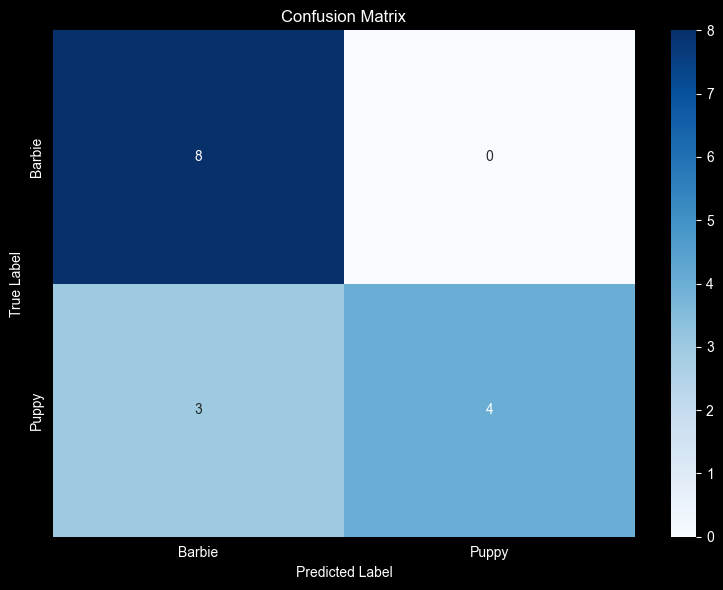

In [172]:
print("ОБУЧЕНИЕ С MFCC+DELTA")

train_dataset_mfcc = AugmentedAudioDataset(
    train_files.tolist(), 
    train_labels.tolist(),
    feature_type='mfcc_delta',
    augmentation=augmentation_pipeline,
    augment_multiplier=AUGMENTATION_MULTIPLIER
)

val_dataset_mfcc = AugmentedAudioDataset(
    val_files.tolist(),
    val_labels.tolist(),
    feature_type='mfcc_delta',
    augmentation=None,
    augment_multiplier=1
)

test_dataset_mfcc = AugmentedAudioDataset(
    test_files.tolist(),
    test_labels.tolist(),
    feature_type='mfcc_delta',
    augmentation=None,
    augment_multiplier=1
)

train_loader_mfcc = DataLoader(train_dataset_mfcc, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_mfcc = DataLoader(val_dataset_mfcc, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_mfcc = DataLoader(test_dataset_mfcc, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model_mfcc = ImprovedAudioCNN().to(device)

criterion_mfcc = nn.CrossEntropyLoss()
optimizer_mfcc = optim.Adam(model_mfcc.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler_mfcc = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_mfcc, mode='min', factor=0.5, patience=5
)

model_mfcc, history_mfcc = train_model_improved(
    model_mfcc, train_loader_mfcc, val_loader_mfcc, criterion_mfcc, 
    optimizer_mfcc, scheduler_mfcc, num_epochs=EPOCHS, patience=15
)

print("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ (MFCC+Delta)")
test_acc_mfcc, test_f1_mfcc = evaluate_model(model_mfcc, test_loader_mfcc)

## Визуализация обучения

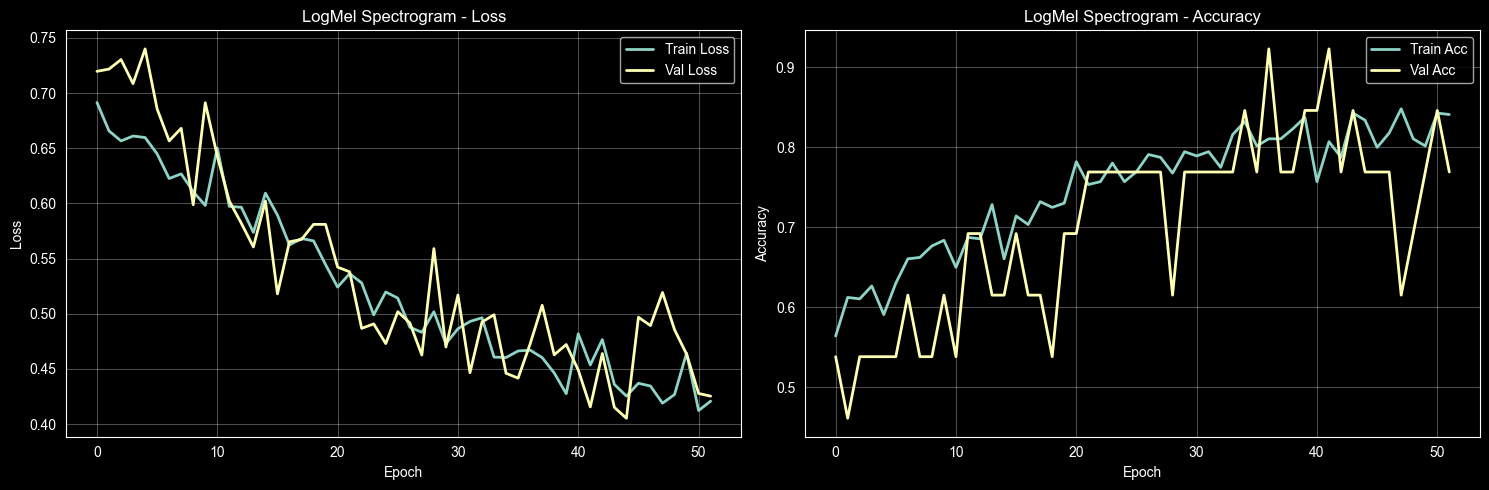

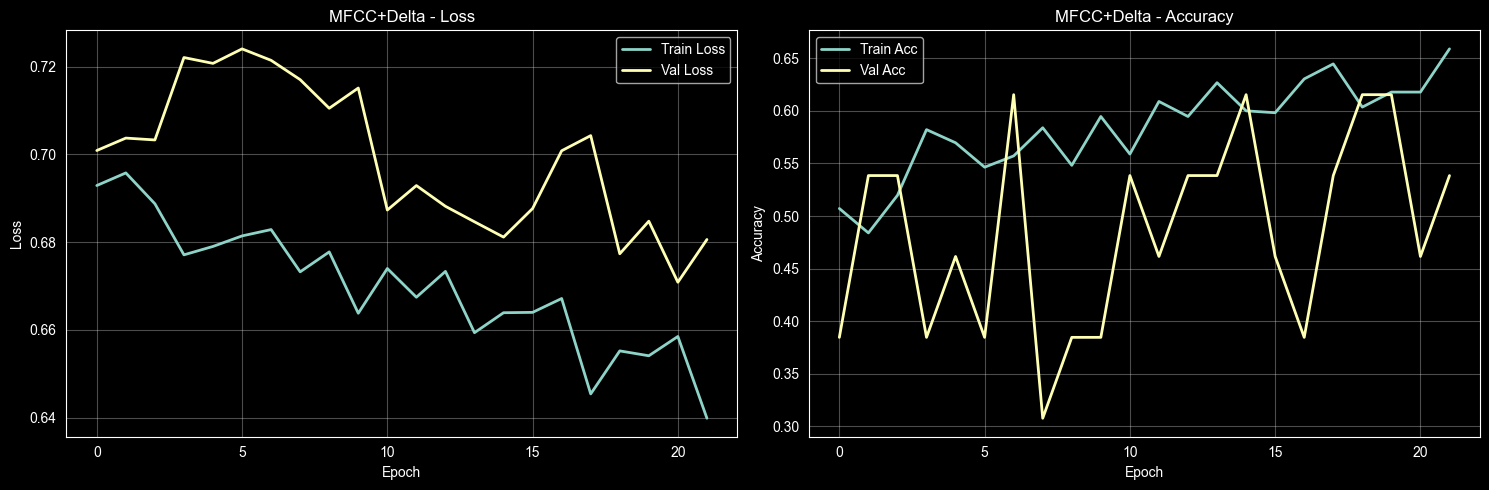

In [173]:
def plot_training_history(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Визуализация
plot_training_history(history_logmel, 'LogMel Spectrogram')
plot_training_history(history_mfcc, 'MFCC+Delta')

## Сравнение результатов

            Method  Test Accuracy  Test F1-Score
LogMel Spectrogram       0.866667       0.865476
        MFCC+Delta       0.800000       0.788517


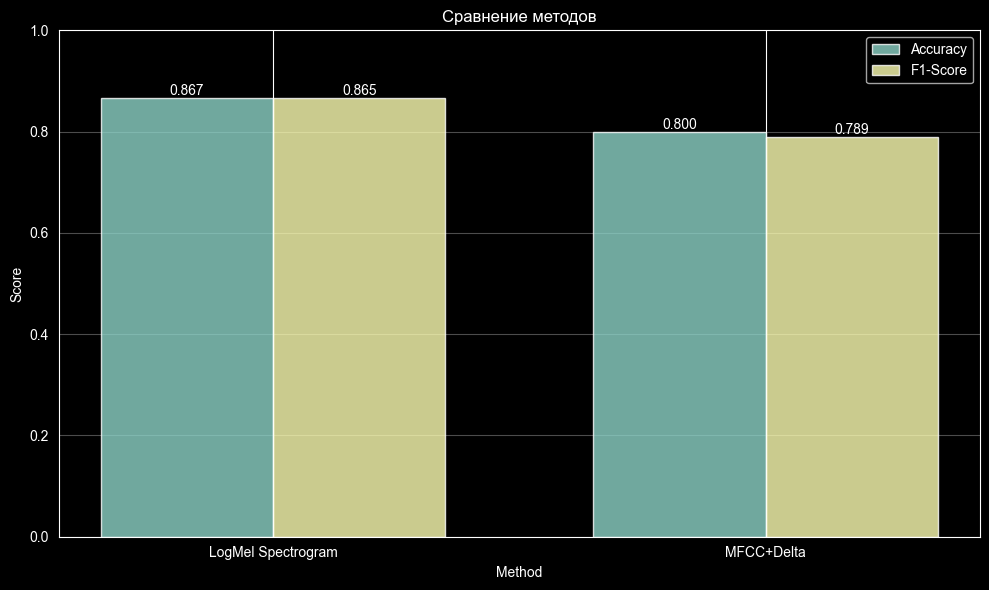

In [174]:
results_summary = pd.DataFrame({
    'Method': ['LogMel Spectrogram', 'MFCC+Delta'],
    'Test Accuracy': [test_acc_logmel, test_acc_mfcc],
    'Test F1-Score': [test_f1_logmel, test_f1_mfcc]
})

print(results_summary.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_summary))
width = 0.35

bars1 = ax.bar(x - width/2, results_summary['Test Accuracy'], width, label='Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, results_summary['Test F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Method')
ax.set_ylabel('Score')
ax.set_title('Сравнение методов')
ax.set_xticks(x)
ax.set_xticklabels(results_summary['Method'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()